# PFDA Project - Winter 2024
*****

## 1. Introduction

This notebook contains an analysis of historical windspeed data recorded by Met Éireann at the Johnstown Castle weather station<sup>[6]</sup> in County Wexford between 12 August 2003 and 01 December 2024<sup>[1]</sup>.

Wind generation is the largest source of renewable energy in Ireland, providing 11.67 TWh of electricity (33.7% of Ireland's electricity supply) in 2023<sup>[3]</sup>. According to the SEAI Energy in Ireland 2024 report, Ireland had an installed wind capacity of 4.74 GW in 2023, with an estimated increase to 4.85 GW in 2024 (an exact figure for 2024 will not be available until Eirgrid and ESB-Netwroks publish their fuill year report for 2024).

## 2. Imports

In [39]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)
from sklearn.pipeline import Pipeline

## 3. Loading and cleaning the datasets

In [40]:
# load data
df=pd.read_csv("datasets/hly1775.csv", skiprows=17, low_memory=False)
df

date  ind rain  ind.1  temp  ind.2  wetb dewpt vappr  \
0       12-aug-2003 01:00   -1           4            4                     
1       12-aug-2003 02:00   -1           4            4                     
2       12-aug-2003 03:00   -1           4            4                     
3       12-aug-2003 04:00   -1           4            4                     
4       12-aug-2003 05:00   -1           4            4                     
...                   ...  ...  ...    ...   ...    ...   ...   ...   ...   
186763  30-nov-2024 20:00    0  0.0      0  13.1      0  12.7  12.5  14.5   
186764  30-nov-2024 21:00    0  0.0      0  13.2      0  12.7  12.3  14.3   
186765  30-nov-2024 22:00    0  0.0      0  13.3      0  12.8  12.3  14.3   
186766  30-nov-2024 23:00    0  3.0      0  13.0      0  12.8  12.6  14.6   
186767  01-dec-2024 00:00    0  0.8      0  13.0      0  12.9  12.7  14.7   

       rhum     msl  ind.3 wdsp  ind.4 wddir  
0                        7           7        
1                        7           7        
2                        7           7        
3                        7           7        
4                        7           7        
...     ...     ...    ...  ...    ...   ...  
186763   96  1010.7      2   17      2   190  
186764   94  1010.3      2   18      2   180  
186765   93  1010.0      2   18      2   190  
186766   97  1009.8      2   15      2   190  
186767   98  1009.3      2   13      2   190  

[186768 rows x 15 columns]

In [41]:
# split date column into date and time columns
df[['date', 'time']] = df['date'].str.split(' ', n=1, expand=True)
# convert date column to datetime 
df["date"]=df['date'].astype('datetime64[ns]')
# set date column as index column
df.set_index('date', inplace=True)

In [42]:
# drop missing values from windspeed data
df["wdsp"]= df.loc[:,("wdsp")].replace(' ', np.nan)
df.dropna(inplace=True)
# convert windspeed values to floats
df['wdsp']=df['wdsp'].astype(float)

In [43]:
df2=pd.read_csv("datasets/WindFarmsConnectedJune2022.csv")
df2


Windfarm_Name DSO_TSO Connection_Ref     County  \
0                 Bellacorrick Wind Farm     DSO          DG955       Mayo   
1                             Corrie Mt.     DSO          DG961    Leitrim   
2                       Mount Cronalaght     DSO          DG974    Donegal   
3                             Golagh (1)     TSO            P25    Donegal   
4               Drumlough Hill Wind Farm     DSO          DG920    Donegal   
..                                   ...     ...            ...        ...   
308                Esk Wind Farm Phase 1     DSO          DG149       Cork   
309     Sorrell Island (Glenmore) WF Ext     DSO         DG1817      Clare   
310  Carrigdangan (formerly Barnadivane)     TSO           TG44       Cork   
311    Clogheravaddy Wind Farm (Phase 2)     DSO         DG269B    Donegal   
312    Patrick Costello Wind Turbine Ext     DSO         DG1849  Tipperary   

    Present_Status  Installed_Capacity__MW_  MEC__MW_       Gate  \
0        Connected                      NaN      6.45   Pre-Gate   
1        Connected                      NaN      4.80   Pre-Gate   
2        Connected                      NaN      4.98   Pre-Gate   
3        Connected                     15.0     15.00   Pre-Gate   
4        Connected                      NaN      4.80   Pre-Gate   
..             ...                      ...       ...        ...   
308      Energised                      NaN      5.95     Gate 2   
309      Energised                      0.0      8.00      ECP-1   
310      Connected                     54.3     54.30     Gate 3   
311      Connected                      0.0     10.80     Gate 3   
312      Energised                      0.0      0.13  Non-Batch   

    F110kV_Node_Name Target_Connection Date_of_Connection  Year_of_Connection  \
0        Bellacorick        01/10/1992         01/10/1992                1992   
1             Arigna               NaN         01/03/1997                1997   
2        Letterkenny        01/07/1997         01/07/1997                1997   
3      Golagh 110 kV               NaN         01/07/1997                1997   
4           Trillick        01/08/1997         01/08/1997                1997   
..               ...               ...                ...                 ...   
308        BOGGERAGH        15/02/2020         16/10/2020                2020   
309        BOOLTIAGH               NaN         30/10/2020                2020   
310  Dunmanway 110kV               NaN         01/01/2021                2021   
311          Binbane               NaN         01/01/2022                2022   
312            CAHIR               NaN         15/03/2022                2022   

     Nat_Grid_E__substation_  Nat_Grid_N__substation_  Type  
0                    98670.0                 321420.0  Wind  
1                   190043.0                 320081.0  Wind  
2                   186118.0                 423981.0  Wind  
3                   203554.0                 382308.0  Wind  
4                   235797.0                 439828.0  Wind  
..                       ...                      ...   ...  
308                 145006.0                  90090.0  Wind  
309                 114719.0                 169051.0  Wind  
310                 134600.0                  63300.0  Wind  
311                 182738.0                 384378.0  Wind  
312                 196297.0                 156240.0  Wind  

[313 rows x 15 columns]

## 4. Examining the data

In [44]:
# describe windspeed column
df["wdsp"].describe()

count    185772.000000
mean          8.111696
std           4.283350
min           0.000000
25%           5.000000
50%           7.000000
75%          11.000000
max          35.000000
Name: wdsp, dtype: float64

In [45]:
# select only data from windfarms located in Co. Wexford
wexford_farms=df2.loc[df2["County"]=="Wexford"]
wexford_farms

Windfarm_Name DSO_TSO Connection_Ref   County  \
21                Carnsore Wind Farm     DSO          DG919  Wexford   
43                    Ballywater (1)     TSO           TG13  Wexford   
62           Richfield Wind Farm (2)     DSO           DG34  Wexford   
64               Richfield Wind Farm     DSO           DG08  Wexford   
72                    Ballywater (2)     TSO           TG35  Wexford   
127               Castledockrell (2)     TSO          DG172  Wexford   
128               Castledockrell (3)     TSO          DG189  Wexford   
129               Castledockrell (1)     TSO           DG88  Wexford   
130               Castledockrell (4)     TSO          DG201  Wexford   
155        Ballycadden Wind Farm (1)     DSO          DG30A  Wexford   
156        Ballycadden Wind Farm (2)     DSO          DG306  Wexford   
159  Ballaman (Kennystown) Wind Farm     DSO          DG126  Wexford   
164            Gibbet Hill Wind Farm     DSO          DG185  Wexford   
168         Knocknalour Wind Farm G3     DSO          DG307  Wexford   
169        Knocknalour Wind Farm (1)     DSO           DG37  Wexford   
170          Ballynancoran Wind Farm     DSO          DG125  Wexford   
216              Ballyduff Wind Farm     DSO          DG323  Wexford   
217              Ballyduff Wind Farm     DSO          DG106  Wexford   

    Present_Status  Installed_Capacity__MW_  MEC__MW_      Gate  \
21       Connected                      NaN    11.900  Pre-Gate   
43       Connected                     31.5    31.500  Pre-Gate   
62       Connected                      NaN     6.750    Gate 1   
64       Connected                      NaN    20.250  Pre-Gate   
72       Connected                     10.5    10.500    Gate 2   
127      Connected                      2.3     2.000    Gate 2   
128      Connected                      2.3     3.300    Gate 2   
129      Connected                     20.7    20.000    Gate 2   
130      Connected                     16.1    16.100    Gate 2   
155      Connected                      NaN    14.450    Gate 1   
156      Energised                      NaN     9.762    Gate 3   
159      Connected                      NaN     3.600    Gate 2   
164      Energised                      NaN    14.800    Gate 2   
168      Connected                      NaN     3.950    Gate 3   
169      Energised                      NaN     5.000    Gate 1   
170      Energised                      NaN     4.000    Gate 2   
216      Energised                      NaN     0.600    Gate 3   
217      Energised                      NaN     4.000    Gate 2   

          F110kV_Node_Name Target_Connection Date_of_Connection  \
21                 Wexford        30/08/2002         30/08/2002   
43       Ballywater 110 kV               NaN         01/05/2005   
62                 Wexford               NaN         01/08/2006   
64                 Wexford               NaN         01/08/2006   
72       Ballywater 110 kV               NaN         01/08/2007   
127  Castledockrell 110 kV               NaN         01/01/2011   
128  Castledockrell 110 kV               NaN         01/01/2011   
129  Castledockrell 110 kV               NaN         01/01/2011   
130  Castledockrell 110 kV        01/12/2010         01/01/2011   
155                  Crory               NaN         12/10/2012   
156                  Crory        12/10/2012         12/10/2012   
159                  Crory        28/09/2012         15/01/2013   
164                  Crory        22/02/2013         29/03/2013   
168                  Crory        20/06/2013         20/06/2013   
169                  Crory        20/06/2013         20/06/2013   
170                  Crory        28/06/2013         03/07/2013   
216                  Crory        01/11/2016         13/01/2017   
217                  Crory        01/11/2016         13/01/2017   

     Year_of_Connection  Nat_Grid_E__substation_  Nat_Grid_N__substation_  \
21                 2002      

As seen in the above data, there are 18 windfarms in County Wexford as of June 2022. It should be noted, however, that this number may not be an accurate reflection of the actual number of windfarms as it may include extensions to existing windfarms and does not include farms/turbines which are not connected to the main electricity grid<sup>[10]</sup>. One of the closest windfarms to the Johnstown Castle weather station is located at Carnsore Point<sup>[7]</sup>, approximately 16km from the weather station<sup>[5]</sup>.

### 4.1. Plots

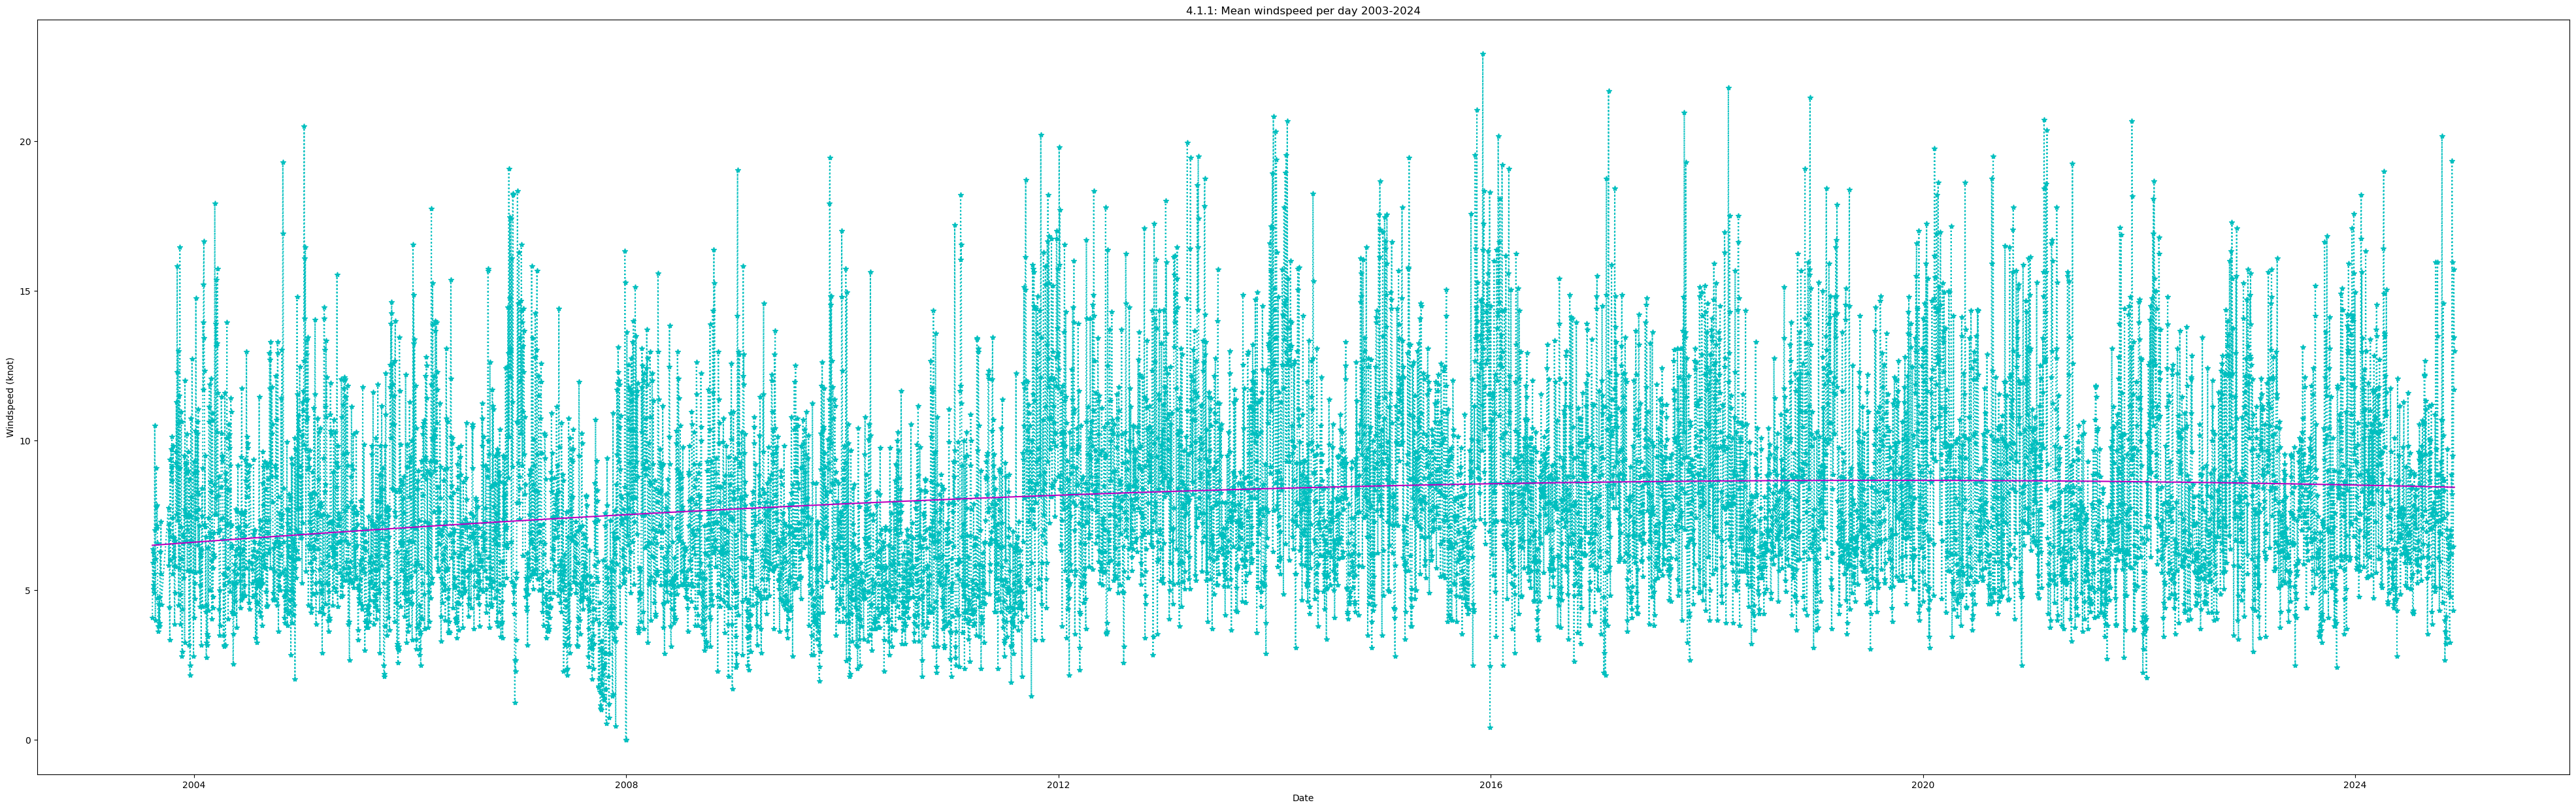

In [46]:
# calculate mean figures for each numerical column per day
mean_per_day=df.groupby([df.index]).mean(numeric_only =True)

# plot windspeed vs date
fig, ax = plt.subplots(figsize=(50,15))

wdsp=mean_per_day["wdsp"]
wdsp=wdsp.to_numpy()
dates = mean_per_day.index
dates_num = mdates.date2num(dates)

# label axes
ax.set_xlabel("Date")
ax.set_ylabel("Windspeed (knot)")
# add title
ax.set_title("4.1.1: Mean windspeed per day 2003-2024")

ax.plot(mean_per_day.index, wdsp, "*:c")
# plot trendline
ax.plot(dates_num, np.poly1d(np.polyfit(dates_num, wdsp, 2))(dates_num), '-m') # reference 4

A program for creating a scrollable version of the above plot is available [here](mean-windspeed-plot.py).

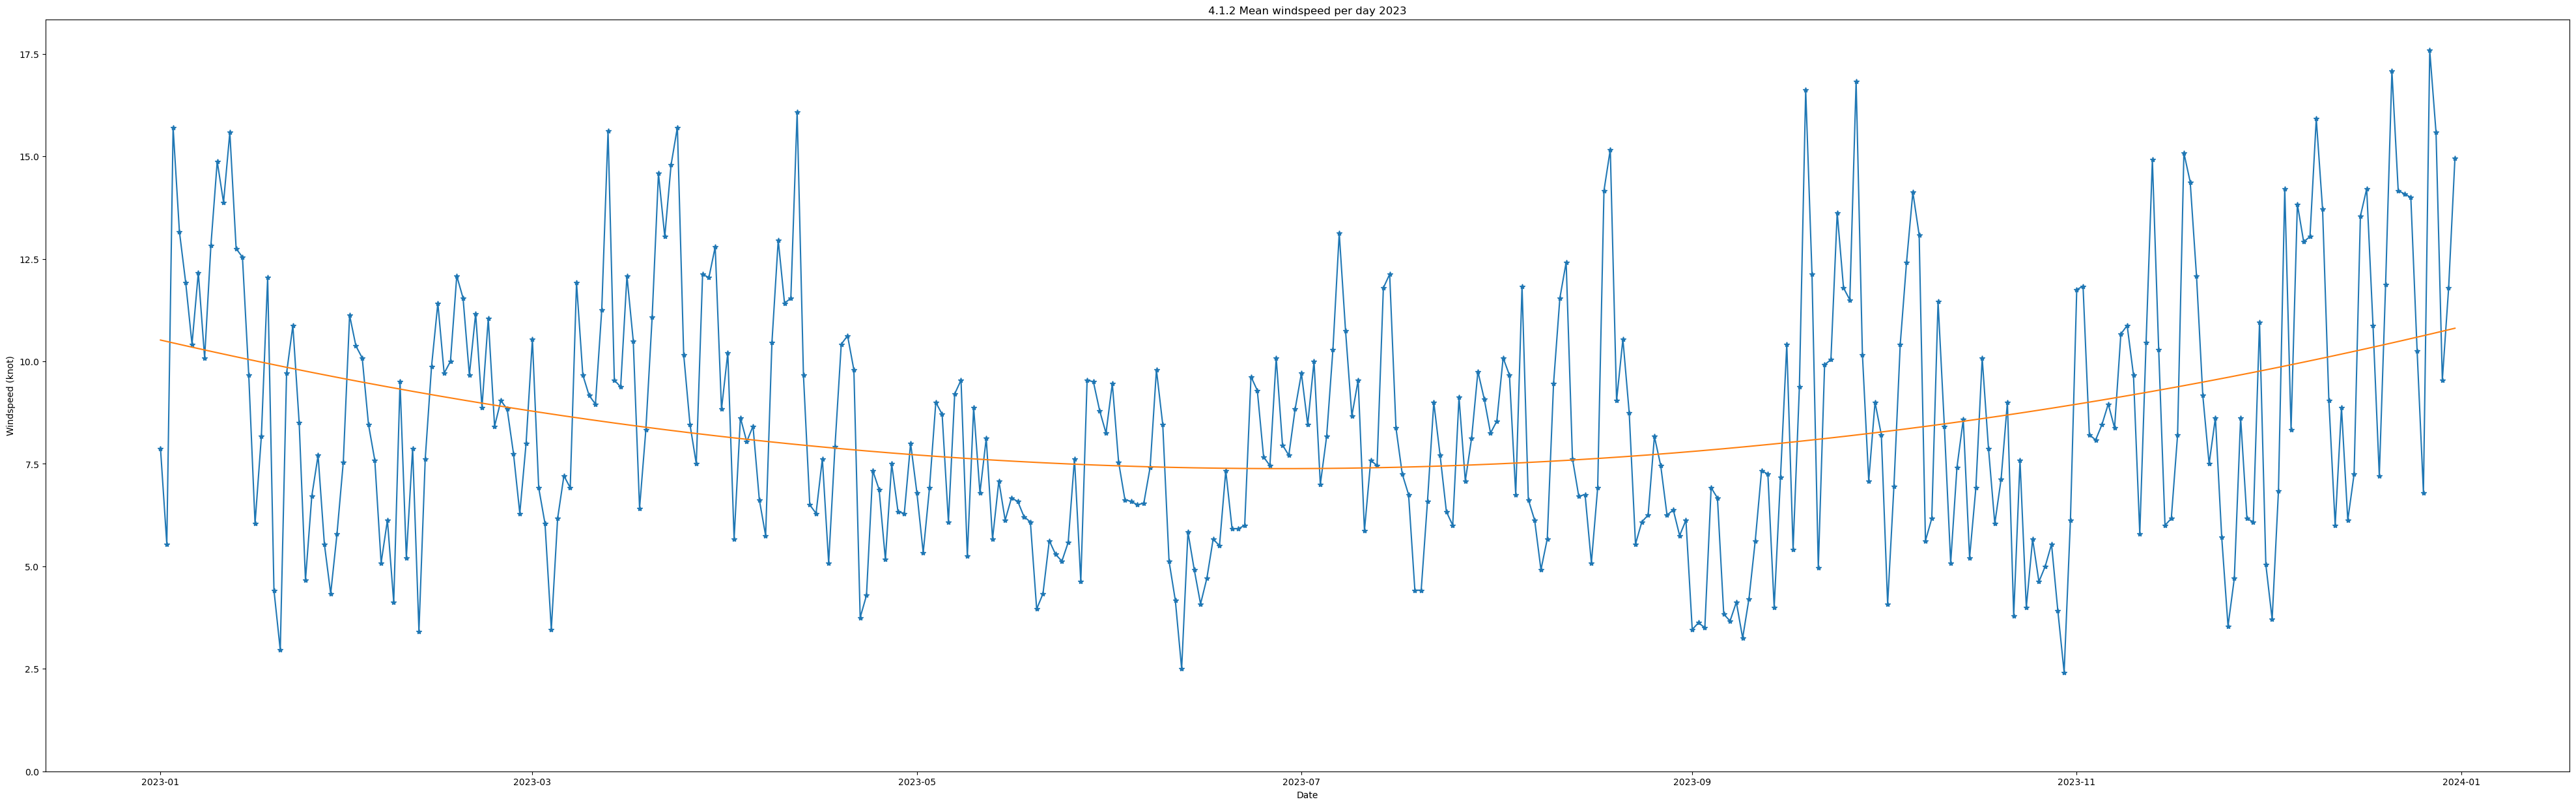

In [47]:
# take the section of the dataset covering 2023
full_year_2023=df.iloc[168971:177731]
# calculate the mean values for 2023
means_2023=full_year_2023.groupby([full_year_2023.index]).mean(numeric_only =True) 

# plot windspeed vs date
fig, ax = plt.subplots(figsize=(50,15))

wdsp_2023=means_2023["wdsp"]
wdsp_2023=wdsp_2023.to_numpy()
dates_2023=means_2023.index
dates_2023_num=mdates.date2num(dates_2023)

# label axes
ax.set_xlabel("Date")
ax.set_ylabel("Windspeed (knot)")
# add title
ax.set_title("4.1.2 Mean windspeed per day 2023")

ax.plot(means_2023.index, wdsp_2023, "*-")
ax.set_ylim(ymin=0)
# plot trendline
ax.plot(dates_2023_num, np.poly1d(np.polyfit(dates_2023_num, wdsp_2023, 2))(dates_2023_num)) # reference 4

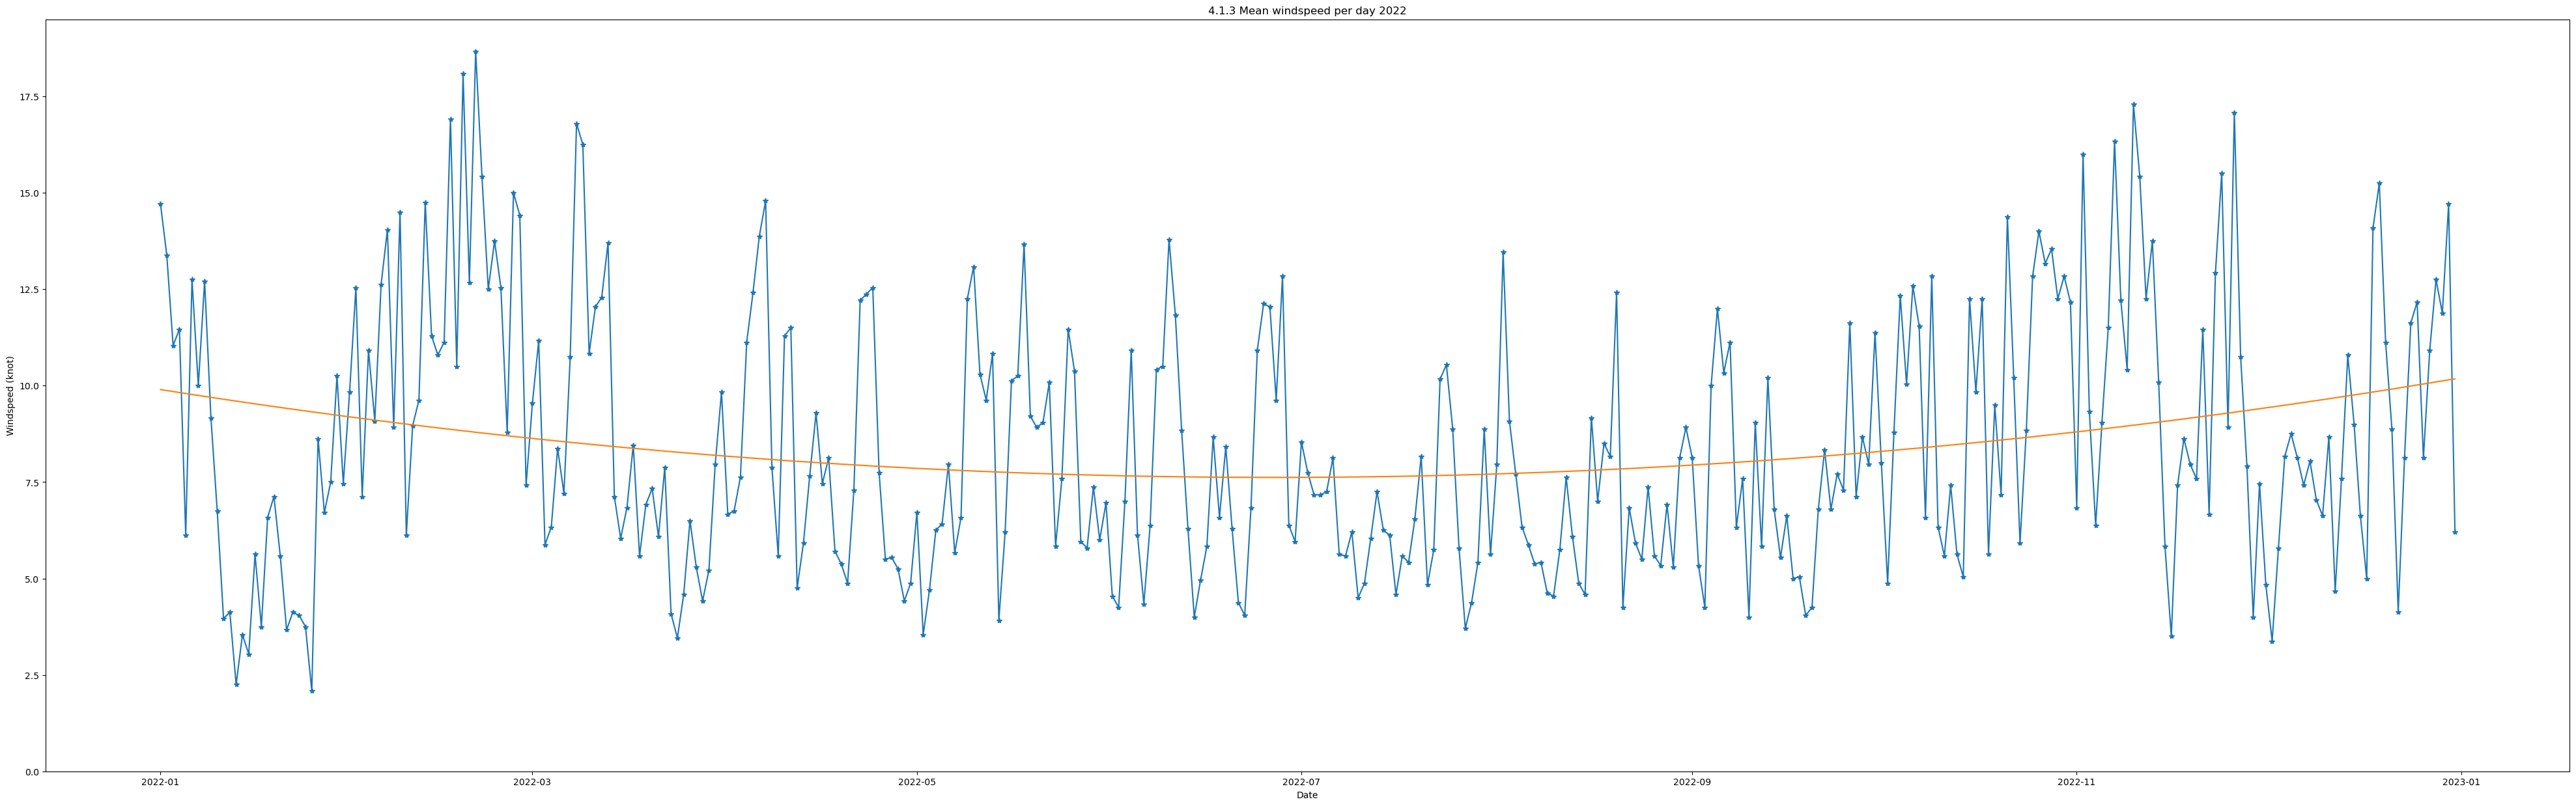

In [48]:
# take the section of the dataset covering 2022
full_year_2022=df.iloc[160211:168971]
# calculate the mean values for 2022
means_2022=full_year_2022.groupby([full_year_2022.index]).mean(numeric_only =True)

# plot windspeed vs date
fig, ax = plt.subplots(figsize=(50,15))

wdsp_2022=means_2022["wdsp"]
wdsp_2022=wdsp_2022.to_numpy()
dates_2022=means_2022.index
dates_2022_num=mdates.date2num(dates_2022)

# label axes
ax.set_xlabel("Date")
ax.set_ylabel("Windspeed (knot)")
# add title
ax.set_title("4.1.3 Mean windspeed per day 2022")

ax.plot(means_2022.index, wdsp_2022, "*-")
ax.set_ylim(ymin=0)
# plot trendline
ax.plot(dates_2022_num, np.poly1d(np.polyfit(dates_2022_num, wdsp_2022, 2))(dates_2022_num)) # reference 4

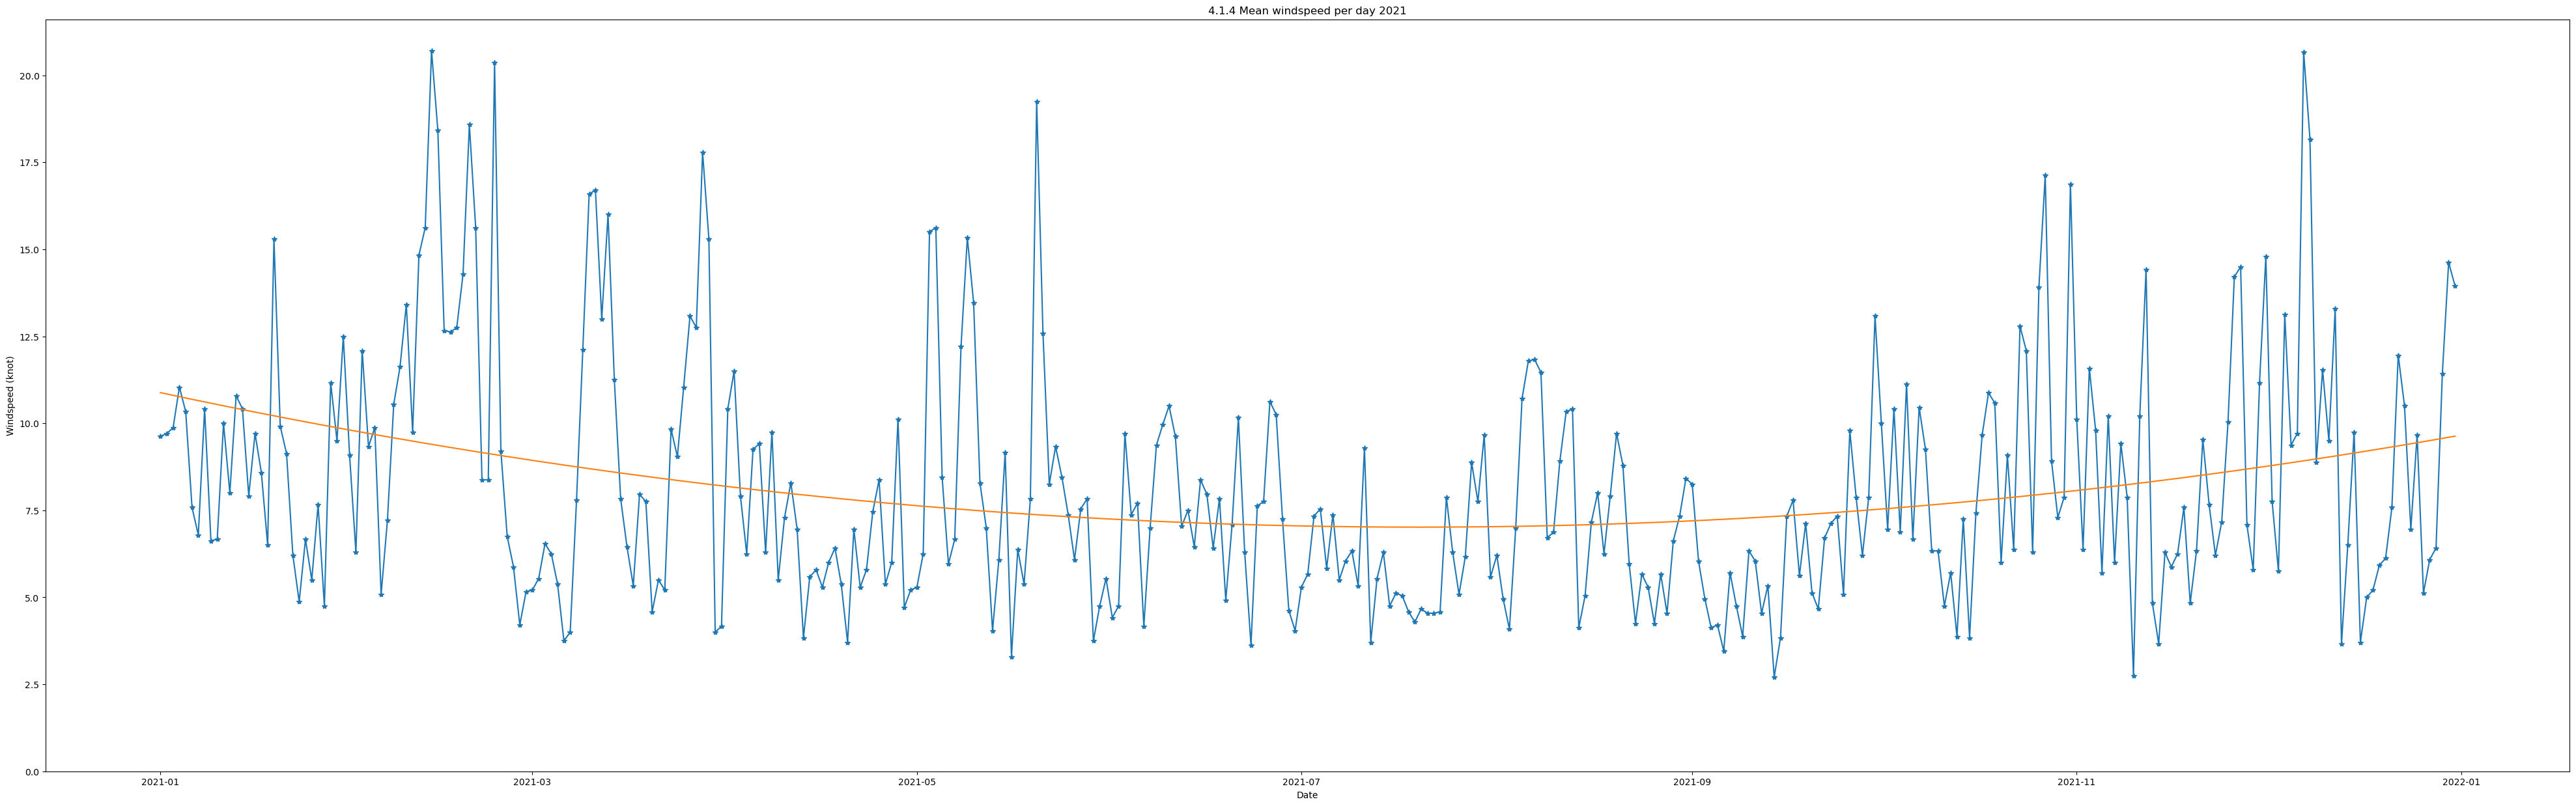

In [49]:
# take the section of the dataset covering 2021
full_year_2021=df.iloc[151451:160211]
# calculate the mean values for 2021
means_2021=full_year_2021.groupby([full_year_2021.index]).mean(numeric_only =True)

# plot windspeed vs date
fig, ax = plt.subplots(figsize=(50,15))

wdsp_2021=means_2021["wdsp"]
wdsp_2021=wdsp_2021.to_numpy()
dates_2021=means_2021.index
dates_2021_num=mdates.date2num(dates_2021)

# label axes
ax.set_xlabel("Date")
ax.set_ylabel("Windspeed (knot)")
# add title
ax.set_title("4.1.4 Mean windspeed per day 2021")

ax.plot(means_2021.index, wdsp_2021, "*-")
ax.set_ylim(ymin=0)
# plot trendline
ax.plot(dates_2021_num, np.poly1d(np.polyfit(dates_2021_num, wdsp_2021, 2))(dates_2021_num)) # reference 4

As seen in the plots above, mean daily windspeed tends to increase during the winter months, giving an opportunity for increasing the amount of energy generation from wind power. This also coincides with a potential increase in demand for energy during the winter months as daylight hours grow shorter and temperatures drop. However, in 2023 renewable energy only satisfied 8% of Ireland's heat demand, with 90.2% being satisfied through the use of fossil fuels<sup>[3]</sup>.

## Predicting windspeed

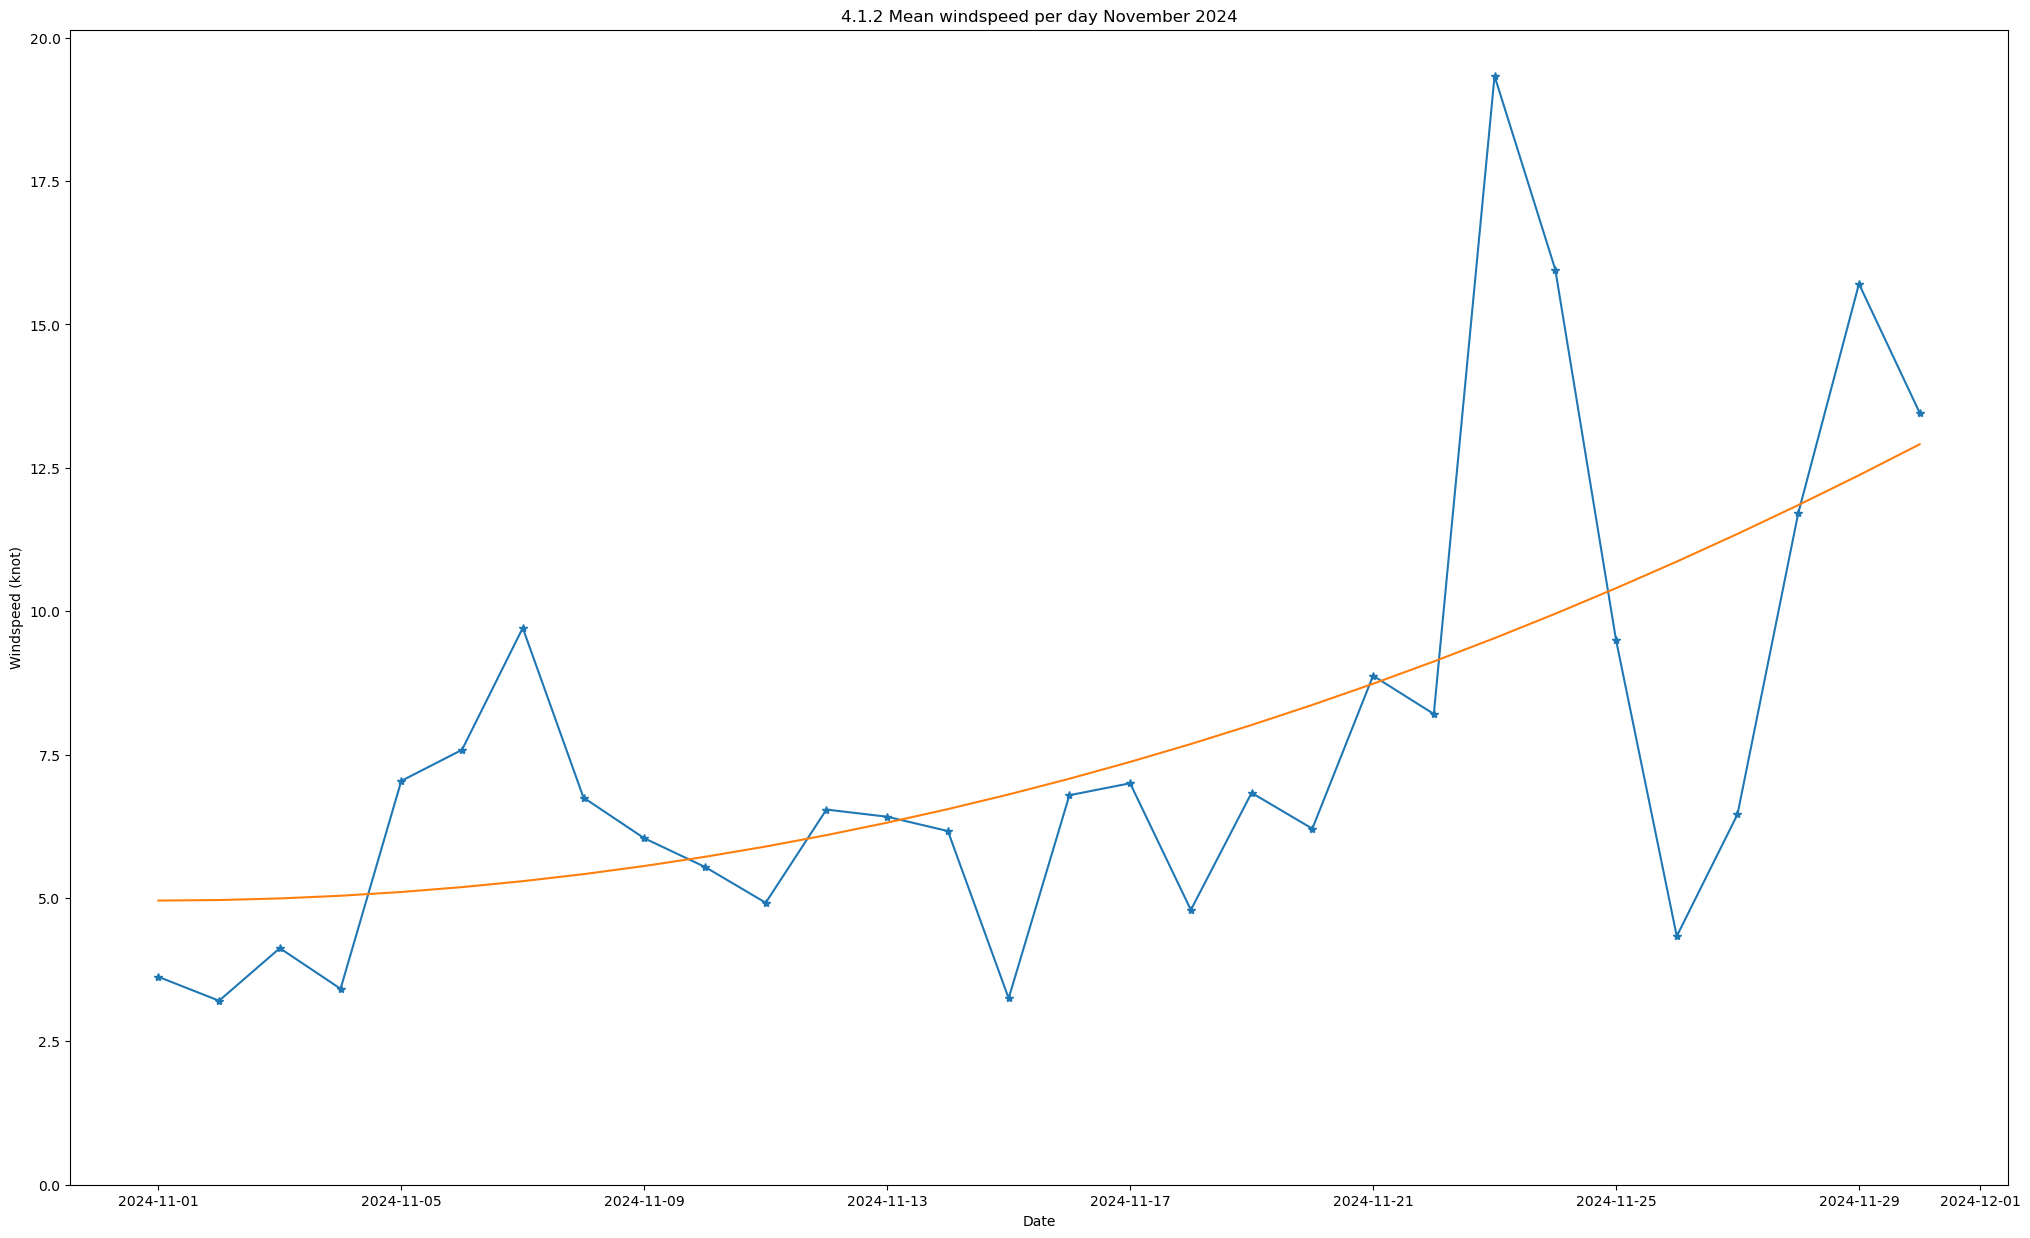

In [50]:
# take the section of the dataset covering november 2024
november=df.iloc[185051:185771]
# calculate the mean values for november 2024
nov_means=november.groupby([november.index]).mean(numeric_only =True)

# plot windspeed vs date
fig, ax = plt.subplots(figsize=(25,15))

nov_wdsp=nov_means["wdsp"]
nov_wdsp=nov_wdsp.to_numpy()
nov_dates=nov_means.index
nov_dates_num=mdates.date2num(nov_dates)

# label axes
ax.set_xlabel("Date")
ax.set_ylabel("Windspeed (knot)")
# add title
ax.set_title("4.1.2 Mean windspeed per day November 2024")

ax.plot(nov_means.index, nov_wdsp, "*-")
ax.set_ylim(ymin=0)
# plot trendline
ax.plot(nov_dates_num, np.poly1d(np.polyfit(nov_dates_num, nov_wdsp, 2))(nov_dates_num)) # reference 4

In [51]:
# reference no. 11
# select training data (everything before november 2024)
train=df.iloc[0:185050]
train=train.groupby([train.index]).mean(numeric_only =True)
x_training=train["wdsp"]
x_training=x_training.to_numpy()
y_training=train.index
y_train_array=mdates.date2num(y_training)
# test data will be windspeed figures for november 2024
x_testing=nov_wdsp
y_testing=nov_dates_num
# combine neighbourhood components analysis with nearest neighbours classifier
comp_ana=NeighborhoodComponentsAnalysis()
k_nbrs=KNeighborsClassifier(n_neighbors=2)
ana_pipe=Pipeline([("comp_ana", comp_ana) ("k_nbrs", k_nbrs)])
# train model
ana_pipe.fit(x_training, y_training)
# use model on test data
print(ana_pipe.score(x_testing, y_testing))
#neighbours=NearestNeighbors(n_neighbors=2, algorithm="ball_tree")
#nov_wdsp=nov_wdsp.reshape(5,6)
#neighbours.fit(nov_wdsp)
#a=neighbours.kneighbors_graph(nov_wdsp)
#a.toarray()

<>:15: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:15: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
C:\Users\sylvi\AppData\Local\Temp\ipykernel_34408\2566515518.py:15: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ana_pipe=Pipeline([("comp_ana", comp_ana) ("k_nbrs", k_nbrs)])


TypeError: 'tuple' object is not callable